In [18]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow import keras
from keras import layers
from functools import partial
from tensorflow.keras.metrics import Accuracy

AUTO = tf.data.experimental.AUTOTUNE
import warnings
warnings.filterwarnings('ignore')


In [19]:
images = glob('train/*/*.jpg')
len(images)

210

In [20]:
#replace backslash with forward slash to avoid unexpected errors
images = [path.replace('\\', '/') for path in images]
df = pd.DataFrame({'filepath': images})
df['label'] = df['filepath'].str.split('/', expand=True)[1]
df.head()

,filepath,label
0,train/benign/not_skin_cancer_00.jpg,benign
1,train/benign/not_skin_cancer_01.jpg,benign
2,train/benign/not_skin_cancer_04.jpg,benign
3,train/benign/not_skin_cancer_05.jpg,benign
4,train/benign/not_skin_cancer_06.jpg,benign


In [21]:
df['label_bin'] = np.where(df['label'].values == 'malignant', 1, 0)
df.head()

,filepath,label,label_bin
0,train/benign/not_skin_cancer_00.jpg,benign,0
1,train/benign/not_skin_cancer_01.jpg,benign,0
2,train/benign/not_skin_cancer_04.jpg,benign,0
3,train/benign/not_skin_cancer_05.jpg,benign,0
4,train/benign/not_skin_cancer_06.jpg,benign,0


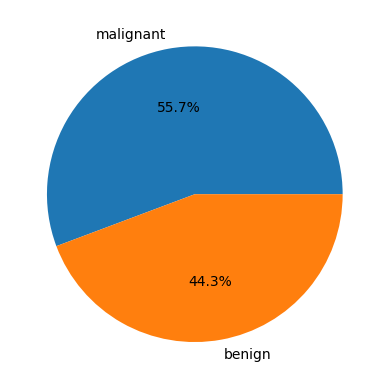

In [22]:
x = df['label'].value_counts()
plt.pie(x.values,
		labels=x.index,
		autopct='%1.1f%%')
plt.show()

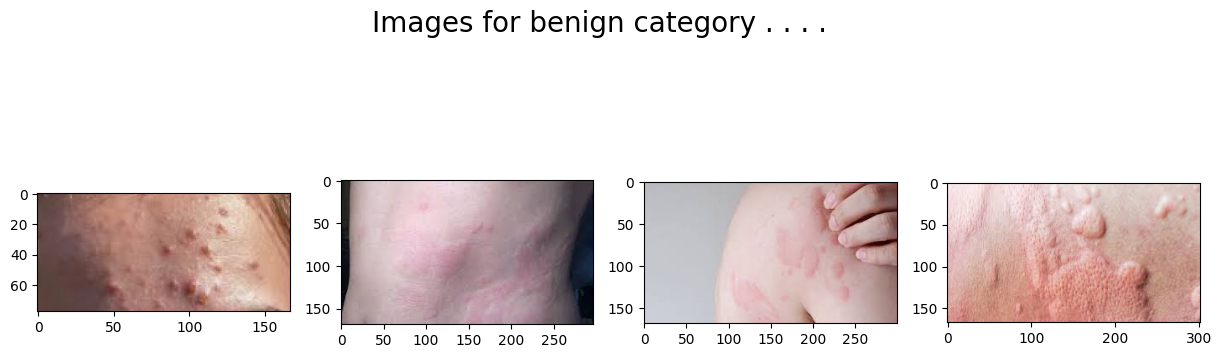

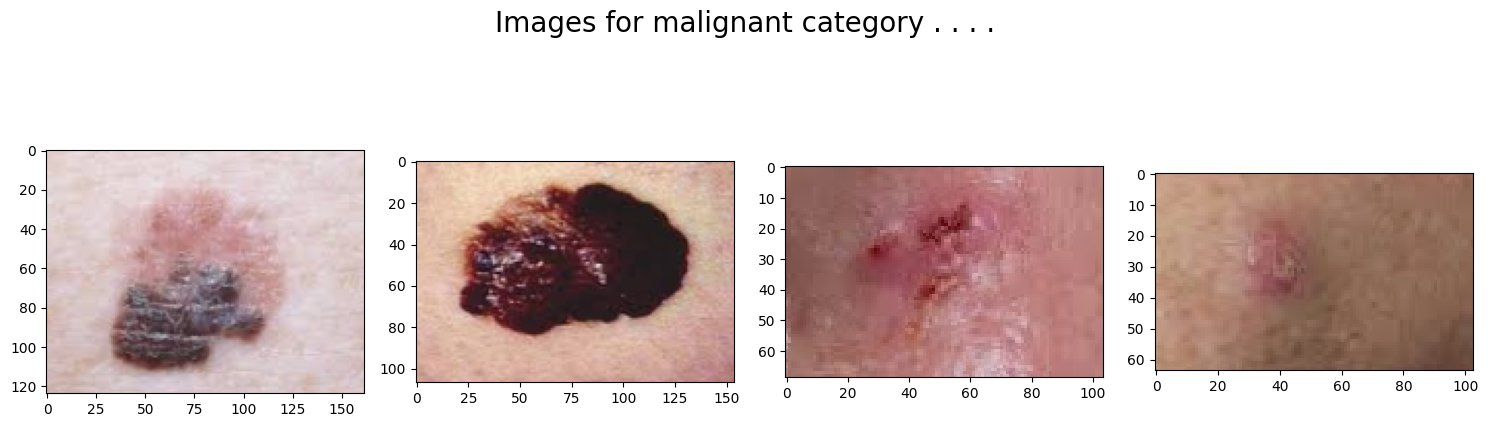

In [23]:
for cat in df['label'].unique():
	temp = df[df['label'] == cat]

	index_list = temp.index
	fig, ax = plt.subplots(1, 4, figsize=(15, 5))
	fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
	for i in range(4):
		index = np.random.randint(0, len(index_list))
		index = index_list[index]
		data = df.iloc[index]

		image_path = data[0]

		img = np.array(Image.open(image_path))
		ax[i].imshow(img)
plt.tight_layout()
plt.show()

In [24]:
features = df['filepath']
target = df['label_bin']

X_train, X_val,\
	Y_train, Y_val = train_test_split(features, target,
									test_size=0.15,
									random_state=10)

X_train.shape, X_val.shape

((178,), (32,))

In [25]:
# def decode_image(filepath, label=None):
#     img = tf.io.read_file(filepath)
#     img = tf.image.decode_jpeg(img)
#     img = tf.image.resize(img, [224, 224])
#     img = tf.cast(img, tf.float32) / 255.0

#     # Convert label to integer if it's not already
#     if label is not None:
#         label = tf.cast(label, tf.int32)

#     return img, label
def decode_image(filepath, label=None):
    # Read image from file
    img = tf.io.read_file(filepath)
    
    # Decode JPEG-encoded image
    img = tf.image.decode_jpeg(img, channels=3)  # Ensure 3 channels
    
    # Resize image to desired dimensions
    img = tf.image.resize(img, [224, 224])
    
    # Normalize pixel values to range [0, 1]
    img = tf.cast(img, tf.float32) / 255.0
    
    # Convert label to integer if it's not already
    if label is not None:
        label = tf.cast(label, tf.int32)

    return img, label

In [26]:
train_ds = (
	tf.data.Dataset
	.from_tensor_slices((X_train, Y_train))
	.map(decode_image, num_parallel_calls=AUTO)
	.batch(32)
	.prefetch(AUTO)
)

val_ds = (
	tf.data.Dataset
	.from_tensor_slices((X_val, Y_val))
	.map(decode_image, num_parallel_calls=AUTO)
	.batch(32)
	.prefetch(AUTO)
)

In [27]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7

pre_trained_model = EfficientNetB7(
	input_shape=(224, 224, 3),
	weights='imagenet',
	include_top=False
)

for layer in pre_trained_model.layers:
	layer.trainable = False

In [28]:
from tensorflow.keras import Model

inputs = layers.Input(shape=(224, 224, 3))
x = layers.Flatten()(inputs)

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)


In [29]:
model.compile(
	loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
	optimizer='adam',
	metrics=['accuracy', 'AUC']
)

In [30]:
history = model.fit(train_ds,
					validation_data=val_ds,
					epochs=20,
					verbose=1)


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 385ms/step - AUC: 0.7584 - accuracy: 0.6944 - loss: 0.6507 - val_AUC: 0.5333 - val_accuracy: 0.5625 - val_loss: 7.6946
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 287ms/step - AUC: 0.9000 - accuracy: 0.8377 - loss: 0.4032 - val_AUC: 0.5000 - val_accuracy: 0.5312 - val_loss: 10.8804
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 286ms/step - AUC: 0.9283 - accuracy: 0.8666 - loss: 0.3412 - val_AUC: 0.5667 - val_accuracy: 0.5312 - val_loss: 4.3623
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 305ms/step - AUC: 0.9512 - accuracy: 0.8964 - loss: 0.2898 - val_AUC: 0.5333 - val_accuracy: 0.5312 - val_loss: 6.0976
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 287ms/step - AUC: 0.9626 - accuracy: 0.9076 - loss: 0.2611 - val_AUC: 0.5333 - val_accuracy: 0.5312 - val_loss: 5.2794
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 290ms/step - AUC: 0.9715 - accuracy: 0.9355 - loss: 0.2270 - val_AUC: 0.8333 - val_accuracy: 0.5625 - val_loss: 2.1356
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 287ms/step -

In [31]:
hist_df = pd.DataFrame(history.history)
hist_df.head()


,AUC,accuracy,loss,val_AUC,val_accuracy,val_loss
0,0.811339,0.735955,0.616886,0.533333,0.56250,7.694605
1,0.890673,0.825843,0.429469,0.500000,0.53125,10.880369
2,0.913958,0.842697,0.375127,0.566667,0.53125,4.362252
3,0.941563,0.870786,0.319233,0.533333,0.53125,6.097647
4,0.952528,0.887640,0.286863,0.533333,0.53125,5.279371


In [32]:
test_loss, test_acc, test_auc = model.evaluate(val_ds)
print('Test Accuracy:', test_acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - AUC: 0.7118 - accuracy: 0.5938 - loss: 2.2522
Test Accuracy: 0.59375


In [34]:
model.save('model.h5')